In [1]:
import pandas as pd
import numpy as np
import requests
import json
import time
import matplotlib.pyplot as plt

## Importing the datasets

In [2]:
pm_data = pd.read_csv("data/pubmed_data_final.csv")
db_data = pd.read_csv("data/dbpedia_data.csv")
mr_data = pd.read_csv("data/medical_records_data.csv")

Standardising the column names and orders for all of the datasets.

In [3]:
# PubMed dataset
pm_data = pm_data[["MeSH Disease Term", "MeSH Symptom Term", "UMLS Disease Code", "UMLS Symptom Code", "TFIDF score"]]
pm_data.columns=["disease", "symptom", "disease_umls", "symptom_umls", "weight"]

In [4]:
# DBpedia dataset
db_data = db_data[["disease", "symptom", "disease_umls", "symptom_umls"]]
db_data["weight"] = 1

In [5]:
pm_data.head()

,disease,symptom,disease_umls,symptom_umls,weight
0,Respiratory Syncytial Virus Infections,"Aging, Premature",C0035235,C0231341,3.464551
1,Orthomyxoviridae Infections,"Aging, Premature",C0276357,C0231341,3.464551
2,HIV Infections,"Aging, Premature",C0019693,C0231341,10.393654
3,Acquired Immunodeficiency Syndrome,"Aging, Premature",C0001175,C0231341,10.393654
4,Breast Neoplasms,"Aging, Premature",C1257931,C0231341,3.464551


In [6]:
db_data.head()

,disease,symptom,disease_umls,symptom_umls,weight
0,Abscess,Erythema,C0000833,C0041834,1
1,Achondroplasia,Macrocephaly,C0001080,C0221355,1
2,Acne,Scar,C0001144,C2004491,1
3,Acrocallosal syndrome,Psychomotor retardation,C0796147,C5441816,1
4,Acrocallosal syndrome,Polydactyly,C0796147,C0152427,1


In [7]:
mr_data.head()

,disease,symptom,disease_umls,symptom_umls
0,hypertensive disease,pain chest,C0020538,C0008031
1,hypertensive disease,shortness of breath,C0020538,C0392680
2,hypertensive disease,dizziness,C0020538,C0012833
3,hypertensive disease,asthenia,C0020538,C0004093
4,hypertensive disease,fall,C0020538,C0085639


## Exploring the datasets

The DBpedia and PubMed datasets have 600 conditions in common.

In [8]:
shared_conditions = set(pd.concat([db_data["disease_umls"], db_data["symptom_umls"]])).intersection(set(pd.concat([pm_data["disease_umls"], pm_data["symptom_umls"]])))
len(shared_conditions)

600

The PubMed and medical records datasets have 160 conditions in common.

In [9]:
shared_conditions = set(pd.concat([mr_data["disease_umls"], mr_data["symptom_umls"]])).intersection(set(pd.concat([pm_data["disease_umls"], pm_data["symptom_umls"]])))
len(shared_conditions)

160

All 3 datasets have only 92 conditions in common. This indicates that the kind of conditions seen in literature (Wikipedia and articles) may be different to those found frequently in reality (in a hospital).

In [10]:
shared_conditions_3 = set(pd.concat([db_data["disease_umls"], db_data["symptom_umls"]]))\
                    .intersection(set(pd.concat([pm_data["disease_umls"], pm_data["symptom_umls"]])))\
                    .intersection(set(pd.concat([mr_data["disease_umls"], mr_data["symptom_umls"]])))
len(shared_conditions_3)

92

The DBpedia and PubMed datasets have 659 edges (associations between diseases and symptoms) in common.

In [11]:
shared_edges = set(pm_data["disease_umls"].astype("string") + "_" + pm_data["symptom_umls"].astype("string")).intersection(set(db_data["disease_umls"].astype("string") + "_" + db_data["symptom_umls"].astype("string")))
len(shared_edges)

659

All 3 datasets have only 36 edges in common. Therefore the information contained within each of these datasets is very different to each other, suggesting that combining them may be useful.

In [12]:
shared_edges_3 = set(pm_data["disease_umls"].astype("string") + "_" + pm_data["symptom_umls"].astype("string"))\
               .intersection(set(db_data["disease_umls"].astype("string") + "_" + db_data["symptom_umls"].astype("string")))\
               .intersection(set(mr_data["disease_umls"].astype("string") + "_" + mr_data["symptom_umls"].astype("string")))
len(shared_edges_3)

36

The mean tfidf weight in the PubMed dataset for associations also shared by the DBpedia dataset is 81, suggesting that their shared associations are ones with a stronger co-occurence score.

In [13]:
pm_data_edges = pd.concat([pm_data["disease_umls"].astype("string") + "_" + pm_data["symptom_umls"].astype("string"), pm_data["weight"]], axis=1).set_index(0)
pm_data_edges.loc[list(shared_edges), :]["weight"].describe()

count     659.000000
mean       81.112748
std       314.644031
min         0.329387
25%         5.268807
50%        17.247568
75%        50.133948
max      5681.060666
Name: weight, dtype: float64

This value has been increased by a few outliers, such as the association between Dizziness and Vertigo, which could arguably be described as the same concept.

In [14]:
pm_data[pm_data["weight"]>5681].head(1)

,disease,symptom,disease_umls,symptom_umls,weight
100388,Dizziness,Vertigo,C0220870,C0155503,5681.060666


## Reducing the number of symptoms associated with diseases

For the 3 datasets to be successfully combined into a single large health knowledge graph, without one data source massively dominating the others, they should have roughly comparable numbers of symptoms associated with each disease as well as comparable edge weights between symptoms to diseases.

The PubMed data has a very high number of symptoms associated with many diseases, whereas the DBpedia dataset is on the other end of the scale, with less than 10 symptoms associated with a disease in almost all cases. The Medical Records dataset sits in between them.

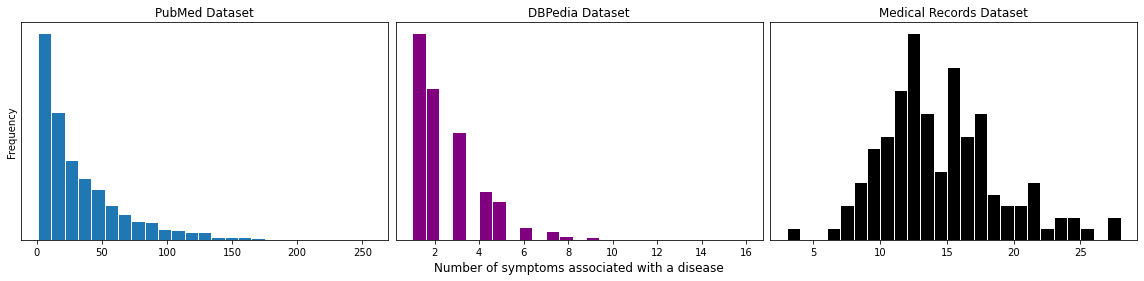

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
fig.subplots_adjust(wspace=0.02)
pm_data.groupby("disease").count()["symptom"].plot.hist(edgecolor="white", bins=25, ax=ax1)
db_data.groupby("disease").count()["symptom"].plot.hist(edgecolor="white", bins=25, color="purple", ax=ax2)
mr_data.groupby("disease").count()["symptom"].plot.hist(edgecolor="white", bins=25, color="black", ax=ax3)
ax1.set_yticks(()), ax2.set_yticks(()), ax3.set_yticks(());
ax2.set_ylabel(""), ax3.set_ylabel(""), ax2.set_xlabel("Number of symptoms associated with a disease", fontsize=12);
ax1.set_title("PubMed Dataset"), ax2.set_title("DBPedia Dataset"), ax3.set_title("Medical Records Dataset");

The PubMed dataset has by far the largest amount of symptoms associated with some diseases, and many of these are very small associations by weight. 

Finding the average tfidf score for the nth most associated symptom to each disease, in the PubMed data.

In [16]:
avg_tfidf = pd.DataFrame([pm_data.sort_values("weight", ascending=False).groupby("disease").nth(i)["weight"].mean() for i in range(0, 20)], columns=["average weight"])
avg_tfidf = avg_tfidf.reset_index()
avg_tfidf["index"] += 1

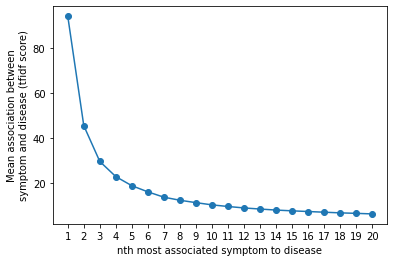

In [17]:
ax = avg_tfidf.plot(x="index", y="average weight", marker='o', legend=False)
plt.xticks(list(range(1, 21)));
ax.set_ylabel("Mean association between\nsymptom and disease (tfidf score)")
ax.set_xlabel("nth most associated symptom to disease");

Looking for possible "elbows" in the plot, symptoms beyond the 10th most associated symptom certainly can likely be dropped, as they have a very low weighted association to their respective disease.

In the medical records data, the symptoms are simply said to be "ranked" by strength of association, however no quantifiable rank is provided. In order to make the dataset comparable to the other two, only the 10th most associated symptoms will also be selected for this dataset.

In [18]:
pm_data_reduced = pm_data.sort_values("weight", ascending=False).groupby("disease").nth[:10]
pm_data_reduced = pm_data_reduced.reset_index()

In [19]:
mr_data_reduced = mr_data.groupby("disease").nth[:10]
mr_data_reduced = mr_data_reduced.reset_index()

In [20]:
pm_data_reduced.shape

(35669, 5)

In [21]:
mr_data_reduced.shape

(1292, 4)

## Standardising the edge weights

If only the 10th most associated symptoms to each disease are selected from the datasets (or fewer, with regards to the DBpedia data), then it is feasible for every edge to have a weight of "1". 

This will ensure that all of the datasets are comparable, and none dominates the others in the final dataset.

In [22]:
pm_data_reduced["weight"] = 1

In [23]:
mr_data_reduced["weight"] = 1

In [24]:
pm_data_reduced.head()

,disease,symptom,disease_umls,symptom_umls,weight
0,22q11 Deletion Syndrome,Respiratory Sounds,C2936346,C0032230,1
1,22q11 Deletion Syndrome,Language Development Disorders,C2936346,C0751257,1
2,22q11 Deletion Syndrome,Olfaction Disorders,C2936346,C0553757,1
3,"46, XX Disorders of Sex Development",Virilism,C0238394,C1452968,1
4,"ACTH Syndrome, Ectopic",Hirsutism,C0001231,C0019572,1


In [25]:
mr_data_reduced.head()

,disease,symptom,disease_umls,symptom_umls,weight
0,Alzheimer's disease,agitation,C0002395,C0085631,1
1,Alzheimer's disease,drool,C0002395,C0013132,1
2,Alzheimer's disease,nightmare,C0002395,C0028084,1
3,Alzheimer's disease,rhonchus,C0002395,C0035508,1
4,Alzheimer's disease,hyperkalemia,C0002395,C0020461,1


In [26]:
db_data.head()

,disease,symptom,disease_umls,symptom_umls,weight
0,Abscess,Erythema,C0000833,C0041834,1
1,Achondroplasia,Macrocephaly,C0001080,C0221355,1
2,Acne,Scar,C0001144,C2004491,1
3,Acrocallosal syndrome,Psychomotor retardation,C0796147,C5441816,1
4,Acrocallosal syndrome,Polydactyly,C0796147,C0152427,1


## Combining the datasets

As the columns and edge weights are already standardised between the datasets, combining them into one single dataset is simple.

In [27]:
combined = pd.concat([pm_data_reduced, db_data, mr_data_reduced])
combined = combined.reset_index(drop=True)

## Standardising the term names between the datasets

It seems as if between the datasets, often a different disease name (term) is used for the same UMLS code. Does this indicate any problems?

In [28]:
combined[["disease", "disease_umls", "symptom", "symptom_umls"]].nunique()

disease         4620
disease_umls    4232
symptom          854
symptom_umls     753
dtype: int64

Based on an examination of the data, this does not seem to indicate a problem. Rather the "different" terms are due to a letter being capitalised or not, or an addition added to the term which does not affect its meaning, i.e. "Anorexia" versus "Anorexia (symptom)".

In [29]:
combined_group = combined.groupby("symptom_umls")["symptom"].nunique()
pd.DataFrame(combined[combined["symptom_umls"].isin(combined_group[combined_group>1].index)].groupby("symptom_umls")["symptom"].value_counts()).head(19)

symptom
symptom_umls symptom                    
C0000727     Abdomen, Acute          405
             abdomen acute             1
C0000737     Abdominal Pain          615
             Abdominal pain           42
             pain abdominal           18
C0002962     Angina Pectoris         240
             angina pectoris           8
             Angina                    2
C0003123     Anorexia                142
             Anorexia (symptom)       11
             anorexia                  5
C0003862     Arthralgia              272
             arthralgia                1
C0003962     Ascites                   9
             ascites                   9
C0004093     Asthenia                 64
             asthenia                 17
C0006625     Cachexia                149
             cachexia                  3

As the UMLS codes are standardised between the datasets, there is no problem in combining them from a technical point of view. However from an understandability point of view, it would be useful to be able to have a readable term (disease name) associated with each code. Therefore these terms will need to also be standardised between the datasets.

In [30]:
all_conditions = list(pd.concat([combined["disease_umls"], combined["symptom_umls"]]).unique())

In [31]:
len(all_conditions)

4591

Using the UMLS API to find the term names from their respective UMLS codes:

In [32]:
base_api = "https://uts-ws.nlm.nih.gov/rest/content/current/CUI/"
apiKey = json.load(open("../umls_api_key.json"))["apiKey"]

Finding the as-of-now depreciated terms in the older UMLS releases:

In [33]:
# more_failed_umls_to_term
print("['C0240100', 'C0847488', 'C0233070']")

['C0240100', 'C0847488', 'C0233070']


Adding the final terms manually:

In [34]:
umls_to_term_df = pd.read_csv("code_maps/umls_to_term_dict.csv")
umls_to_term = umls_to_term_df.set_index("umls_code").to_dict()["term"]

In [35]:
umls_to_term_df.head()

,umls_code,term
0,C0035235,Respiratory Syncytial Virus Infections
1,C0276357,Swine influenza
2,C0019693,HIV Infections
3,C0001175,Acquired Immunodeficiency Syndrome
4,C1257931,"Mammary Neoplasms, Human"


Mapping every UMLS code to the term as defined in the mapping, to ensure consistency throughout the dataset:

In [36]:
combined["disease"] = combined["disease_umls"].map(umls_to_term)
combined["symptom"] = combined["symptom_umls"].map(umls_to_term)

Now each UMLS code is associated with the same term.

In [37]:
combined[["disease", "disease_umls", "symptom", "symptom_umls"]].nunique()

disease         4232
disease_umls    4232
symptom          753
symptom_umls     753
dtype: int64

## Combining duplicate rows

Edges (associations) that are shared between the datasets have their weights summed, thus increasing the weight between a symptom and disease, if multiple datasets agree on that association.

In [38]:
full_hkg = pd.DataFrame(combined.groupby(["disease", "symptom", "disease_umls", "symptom_umls"])["weight"].sum()).reset_index()

In [39]:
full_hkg.head()

,disease,symptom,disease_umls,symptom_umls,weight
0,22q11 Deletion Syndrome,"Auditory Processing Disorder, Central",C2936346,C0751257,1
1,22q11 Deletion Syndrome,Olfaction Disorders,C2936346,C0553757,1
2,22q11 Deletion Syndrome,Pleural Rub,C2936346,C0032230,1
3,"ACTH Syndrome, Ectopic",Abdominal Pain,C0001231,C0000737,1
4,"ACTH Syndrome, Ectopic",Ecchymosis,C0001231,C0013491,1


We can also see a filtered knowledge graph, looking only at weights greater than 1 (multiple datasets agree on the association).

In [40]:
full_hkg[full_hkg["weight"]>1].reset_index(drop=True).head(10)

,disease,symptom,disease_umls,symptom_umls,weight
0,Abdominal Migraine,Hemicrania,C0270858,C0877781,2
1,Abdominal Migraine,Nausea,C0270858,C0027497,2
2,Abdominal Migraine,Photophobia,C0270858,C0085636,2
3,Abruptio Placentae,Abdominal Pain,C0000832,C0000737,2
4,Acoustic Neuroma,"Tinnitus, Tensor Palatini Induced",C0027859,C0751557,2
5,Acquired Immunodeficiency Syndrome,Diarrhea,C0001175,C0011991,2
6,Acquired Immunodeficiency Syndrome,Fever,C0001175,C0015967,3
7,Acute Cerebrovascular Accidents,"Hemiplegia, Infantile",C0751956,C0392550,2
8,Acute Coryza,Coughing,C0086066,C0010200,2
9,Acute Coryza,Fever,C0086066,C0015967,2


In [41]:
full_hkg.shape

(37588, 5)

In [42]:
full_hkg[full_hkg["weight"]>1].shape

(507, 5)

## Reshaping the dataset to be suitable for import to Gephi

The data must be reshaped into two different tables: one containing all of the nodes and their labels, and another describing the edges between the given nodes.

### Creating a "nodes" table

Creating a dataframe that contains only each "node", i.e. each disease or symptom, and its associated UMLS code. Starting by including all of the diseases:

In [43]:
nodes_table = full_hkg.copy()[["disease_umls", "disease"]]
nodes_table.columns = ["Id", "Label"]

Then adding all of the symptoms to the table:

In [44]:
nodes_table = pd.concat([nodes_table, full_hkg[["symptom_umls", "symptom"]].rename(columns={"symptom_umls":"Id", "symptom":"Label"})])

394 conditions exist as both a symptom and a disease, thus the duplicate diseases/symptoms must be removed:

In [45]:
len(set(full_hkg["disease_umls"]).intersection(set(full_hkg["symptom_umls"])))

394

In [46]:
nodes_table = nodes_table.drop_duplicates()

Checking that the UMLS codes are all correct:

In [47]:
nodes_table.nunique()

Id       4591
Label    4591
dtype: int64

Adding an optional column, indicating whether a condition is either a disease or symptom. The classification is not clear cut, because some conditions can exist as either a disease or a symptom. "Symptom" is chosen to take priority, due to the fewer number of symptoms in the dataset.

In [48]:
print("Number of symptoms:", full_hkg["symptom"].nunique(), 
"\nNumber of diseases:", full_hkg["disease"].nunique(), 
"\nNumber of conditions existing as both a symptom and disease:", len(set(full_hkg["symptom"]).intersection(set(full_hkg["disease"]))))

Number of symptoms: 753 
Number of diseases: 4232 
Number of conditions existing as both a symptom and disease: 394


In [49]:
nodes_table["condition"] = nodes_table["Id"].isin(full_hkg["symptom_umls"].unique()).replace({True: "symptom", False: "disease"})

In [50]:
nodes_table

,Id,Label,condition
0,C2936346,22q11 Deletion Syndrome,disease
3,C0001231,"ACTH Syndrome, Ectopic",disease
13,C1306214,ACTH-Secreting Pituitary Adenoma,disease
17,C0752330,"AIDS Arteritis, Central Nervous System",disease
20,C0001849,AIDS Dementia Complex,disease
...,...,...,...
34673,C0234450,Sleepy,symptom
35013,C0234133,Extrapyramidal sign,symptom
35143,C0008767,Cicatrization,symptom
35150,C0338656,Impaired cognition,symptom


There are 4591 unique diseases/symptoms in the combined dataset.

In [51]:
nodes_table.shape

(4591, 3)

### Creating an "edges" table

In [52]:
edges_table = full_hkg.copy()

Creating columns for:  
* the source and target of the edge (the two nodes)
* the label for the edge 
* the unique id for the edge
* the type of edge (directed)
* the weight of the edge - I choose to  use the tfidf score for the edge weights

In [53]:
edges_table

,disease,symptom,disease_umls,symptom_umls,weight
0,22q11 Deletion Syndrome,"Auditory Processing Disorder, Central",C2936346,C0751257,1
1,22q11 Deletion Syndrome,Olfaction Disorders,C2936346,C0553757,1
2,22q11 Deletion Syndrome,Pleural Rub,C2936346,C0032230,1
3,"ACTH Syndrome, Ectopic",Abdominal Pain,C0001231,C0000737,1
4,"ACTH Syndrome, Ectopic",Ecchymosis,C0001231,C0013491,1
...,...,...,...,...,...
37583,"von Willebrand Disease, Recessive Form",Oral Hemorrhage,C1848525,C0029163,1
37584,"von Willebrand Disease, Recessive Form",Purpura,C1848525,C0034150,1
37585,"von Willebrand Disease, Recessive Form",Thrombocytopenic purpura,C1848525,C0857305,1
37586,"von Willebrand Disease, Recessive Form","Waterhouse-Friderichsen Syndrome, Meningococcal",C1848525,C1403891,1


In [54]:
edges_table.columns = ["disease", "symptom", "Source", "Target", "Weight"]
edges_table["Label"] = "Edge from " + edges_table["disease"] + " to " + edges_table["symptom"]
edges_table["Id"] = edges_table["Source"] + "_" + edges_table["Target"]
edges_table["Type"] = "Directed"

In [55]:
edges_table = edges_table[["Source", "Target", "Type", "Id", "Label", "Weight"]]
edges_table

,Source,Target,Type,Id,Label,Weight
0,C2936346,C0751257,Directed,C2936346_C0751257,Edge from 22q11 Deletion Syndrome to Auditory ...,1
1,C2936346,C0553757,Directed,C2936346_C0553757,Edge from 22q11 Deletion Syndrome to Olfaction...,1
2,C2936346,C0032230,Directed,C2936346_C0032230,Edge from 22q11 Deletion Syndrome to Pleural Rub,1
3,C0001231,C0000737,Directed,C0001231_C0000737,"Edge from ACTH Syndrome, Ectopic to Abdominal ...",1
4,C0001231,C0013491,Directed,C0001231_C0013491,"Edge from ACTH Syndrome, Ectopic to Ecchymosis",1
...,...,...,...,...,...,...
37583,C1848525,C0029163,Directed,C1848525_C0029163,"Edge from von Willebrand Disease, Recessive Fo...",1
37584,C1848525,C0034150,Directed,C1848525_C0034150,"Edge from von Willebrand Disease, Recessive Fo...",1
37585,C1848525,C0857305,Directed,C1848525_C0857305,"Edge from von Willebrand Disease, Recessive Fo...",1
37586,C1848525,C1403891,Directed,C1848525_C1403891,"Edge from von Willebrand Disease, Recessive Fo...",1


There are 37,588 connections between diseases and symptoms in the combined dataset.

In [56]:
edges_table.shape

(37588, 6)

Saving the nodes and edges table as csv, for import to Gephi:

## References

Zhou, X., Menche, J., Barabási, A. L., & Sharma, A. (2014). Human symptoms–disease network. Nature communications, 5(1), 1-10. Dataset released under Creative Commons Attribution v4.0 International licence.  
DBPedia dataset (https://dbpedia.org/) released under Creative Commons Attribution-ShareAlike 3.0   
Wang X, Chused A, Elhadad N, Friedman C, Markatou M. Automated knowledge acquisition from clinical narrative reports. AMIA Annu Symp Proc. 2008 Nov 6;2008:783-7. PMID: 18999156; PMCID: PMC2656103.

The UMLS API: https://documentation.uts.nlm.nih.gov/rest/search/#searchType  
*This product uses publicly available data from the U.S. National Library of Medicine (NLM), National Institutes of Health, Department of Health and Human Services; NLM is not responsible for the product and does not endorse or recommend this or any other product.*